In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from util.bilrc_util import read_ns1_data, logtime_r2
from util.fitting import fit_multi_exponential, eval_exp_fit

In [2]:
# Load data from binary files
neg_data = read_ns1_data('data/030722_s1_RTDP_alone_2.ns1')
pyo50_data = read_ns1_data('data/030722_s2_RTDP_50uMPYO_1.ns1')
pyo500_data = read_ns1_data('data/030722_s3_RTDP_500uMPYO_1.ns1')

samples = list(zip('0 $\mu$M PYO,50 $\mu$M PYO,500 $\mu$M PYO'.split(','),
                   [neg_data, pyo50_data, pyo500_data]))

for t, s in samples:
    print(s)
    
neg_data.T

<NS1Data excitation=355nm emission=650nm shots=500 points=10000 points_per_second=1000000000.0 fname="data/030722_s1_RTDP_alone_2.ns1"">
<NS1Data excitation=355nm emission=650nm shots=500 points=10000 points_per_second=1000000000.0 fname="data/030722_s2_RTDP_50uMPYO_1.ns1"">
<NS1Data excitation=355nm emission=650nm shots=500 points=10000 points_per_second=1000000000.0 fname="data/030722_s3_RTDP_500uMPYO_1.ns1"">


array([-5.0000000e-07, -4.9899990e-07, -4.9799980e-07, ...,
        9.4979998e-06,  9.4989999e-06,  9.5000000e-06])

In [3]:
list(samples)

[('0 $\\mu$M PYO', <util.bilrc_util.NS1Data at 0x7ff755409be0>),
 ('50 $\\mu$M PYO', <util.bilrc_util.NS1Data at 0x7ff755283d90>),
 ('500 $\\mu$M PYO', <util.bilrc_util.NS1Data at 0x7ff755283e50>)]

In [4]:
pal = sns.color_palette('dark')

def _do_fit(ts, ys, ns=(1,2)):
    """Performs fitting for different exponential models.
    
    Args:
        ts: timepoints for fitting.
        ys: y values.
        ns: the orders of multi-exponential models to test.
            i.e. 1 indicates single exponential, 2 bi-exponential, etc. 
        
    Returns:
        A dictionary of results indexed by n values.
    """
    res = dict()
    best_n, best_r2 = None, -1
    for n in ns:
        prefactors, exps, red_chi_sq = fit_multi_exponential(
            n, fitting_ts, fitting_ys)
    
        pred_ys = eval_exp_fit(fitting_ts, prefactors, exps)
        r2 = r2_score(fitting_ys, pred_ys)
        res[n] = dict(prefactors=prefactors, exponents=exps,
                      reduced_chi_sq=red_chi_sq, r2=r2)
        
        # Prefer lower order models if compromise in fit quality is small
        better = np.abs(best_r2 - r2) > 0.01 and r2 > best_r2
        if not best_n or better:
            best_n = n
            best_r2 = r2

    return res, best_n

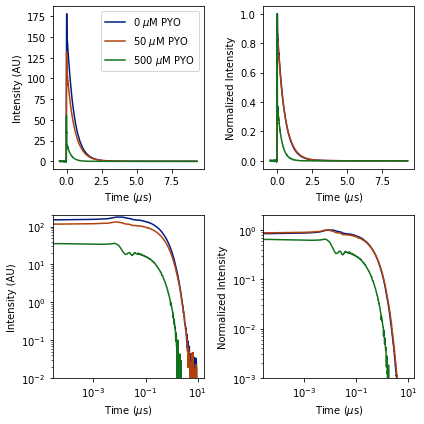

In [5]:
# Figure showing all 3 samples together pre- and post-normalization.
fig, axs = plt.subplots(figsize=(6,6), ncols=2, nrows=2)

# Plot blanked data
for ax, scale in zip(axs[:,0], 'linear,log'.split(',')):
    plt.sca(ax)
    plt.xscale(scale)
    plt.yscale(scale)
    for i, (sname, sdata) in enumerate(samples):
        plt.plot(sdata.t*1e6, sdata.y, color=pal[i], label=sname)
        plt.ylabel('Intensity (AU)')
        plt.xlabel('Time ($\mu$s)')
        #plt.ylim(-10, 200)
    
    if scale == 'linear':
        plt.legend(loc='best')
    if scale == 'log':
        plt.ylim(1e-2,2e2)

# Plot normalized blanked data
for ax, scale in zip(axs[:,1], 'linear,log'.split(',')):
    plt.sca(ax)
    plt.xscale(scale)
    plt.yscale(scale)
    for i, (sname, sdata) in enumerate(samples):
        ys_norm = sdata.y/sdata.y.max()

        plt.plot(sdata.t*1e6, ys_norm, color=pal[i], label=sname)
        plt.ylabel('Normalized Intensity')
        plt.xlabel('Time ($\mu$s)')
        
    if scale == 'log':
        plt.ylim(1e-3,2e0)
        
    
plt.tight_layout()
plt.show()
    

N = 1; exps = [1.74133102], R2 = 0.9928427834570296
N = 2; exps = [1.96273279 1.96335797], R2 = 0.9997922354537692
Chosen fit is order 1 exponential
y = 0.859 exp(1.74 t)
N = 1; exps = [1.76865918], R2 = 0.9984042819731601
N = 2; exps = [1.87823464 1.86264035], R2 = 0.9997197418275928
Chosen fit is order 1 exponential
y = 0.846 exp(1.77 t)
N = 1; exps = [3.21001843], R2 = 0.991480823201429
N = 2; exps = [3.24737788 3.20197267], R2 = 0.9914813889255752
Chosen fit is order 1 exponential
y = 0.395 exp(3.21 t)


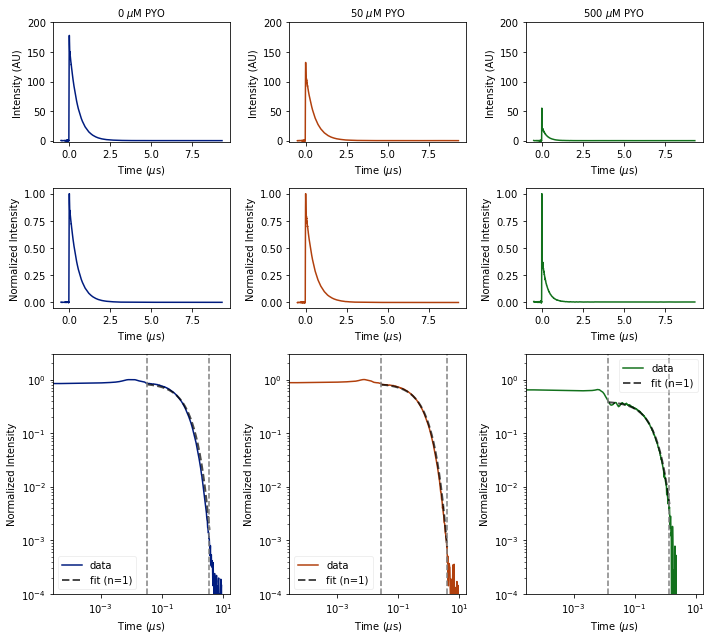

In [6]:
# Figure showing data and fitting along the columns
fig, axs = plt.subplots(figsize=(10,9), ncols=3, nrows=3, gridspec_kw=dict(height_ratios=[1,1,2]))

for i, (sname, sdata) in enumerate(samples):
    ax = axs[0,i]
    plt.sca(ax)
    
    plt.plot(sdata.t*1e6, sdata.y, color=pal[i])
    plt.ylabel('Intensity (AU)')
    plt.ylim(-3, 200)
    
    plt.xlabel('Time ($\mu$s)')
    plt.title(sname, fontsize=10)
    
for i, (sname, sdata) in enumerate(samples):
    ys_norm = sdata.y/sdata.y.max()
    ax = axs[1,i]
    plt.sca(ax)
    
    plt.plot(sdata.t*1e6, ys_norm, color=pal[i])
    plt.ylabel('Normalized Intensity')    
    plt.xlabel('Time ($\mu$s)')
    
for i, (sname, sdata) in enumerate(samples):
    ys_norm = sdata.y/sdata.y.max()

    ax = axs[2,i]
    plt.sca(ax)
    
    # Start fitting a bit after the maximum intensity
    start_idx = ys_norm.argmax() + 20
    tstart = sdata.t[start_idx]
    
    # Endpoint is chosen as either the end of the data or the 
    # point where a windowed std-dev exceeds 25% of the mean.
    y_series = pd.Series(ys_norm[start_idx:])
    t_series = pd.Series(sdata.t[start_idx:])
    rolling_CV = y_series.rolling(5).std()
    rolling_CV /= y_series.rolling(5).mean()
    rolling_t = t_series.rolling(5).mean()
    mask = np.abs(rolling_CV) > 0.25
    if mask.any():
        end_idx = np.where(mask)[0][0]
        tend = rolling_t[end_idx]
    else:
        end_idx = t_series.size - 1
        tend = t_series.values[-1]
    
    fitting_ts = sdata.t[start_idx:start_idx+end_idx]
    fitting_ys = ys_norm[start_idx:start_idx+end_idx]
    
    # Fit single and bi-exponentials
    fit_results, best_n = _do_fit(fitting_ts, fitting_ys)
    print('\n'.join(['N = {0}; exps = {1}, R2 = {2}'.format(n, d['exponents']*1e-6, d['r2'])
                     for n, d in fit_results.items()]))
    print('Chosen fit is order', best_n, 'exponential')
    
    # Predict from fit
    prefactors  = fit_results[best_n]['prefactors']
    exps  = fit_results[best_n]['exponents']
    pred_ys = eval_exp_fit(fitting_ts, prefactors, exps)
    exp_strs = ['{0:.3g} exp({1:.3g} t)'.format(p,e*1e-6) for p,e in zip(prefactors, exps)]
    title = 'y = ' + ' + '.join(exp_strs)
    print(title)

    plt.loglog(sdata.t*1e6, ys_norm, color=pal[i], label='data')
    plt.loglog(fitting_ts*1e6, pred_ys, color='k', ls='--', alpha=0.7,
               lw=2, label='fit (n={0})'.format(best_n))
    plt.axvline(tstart*1e6, color='grey', ls='--')
    plt.axvline(tend*1e6, color='grey', ls='--')

    plt.legend(framealpha=0.3)
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Time ($\mu$s)')
    plt.ylim(1e-4, 3)
    
plt.tight_layout()
plt.savefig('/Users/flamholz/Desktop/030822_fitting_multi_exp.png', facecolor='w',
            dpi=600)
plt.show()
